In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%precision %.5f
plt.rc('text', usetex=True)
plt.rc('font',**{'family':'serif','serif':['Palatino']})

# Constants

In [3]:
DATA_DIR = "classification_data_HWK2/"
COLS = ["red", "blue","green", "orange", "black", "cyan"]
MARKS = ["^","+","*","o","x","."]

## Reading data

In [9]:
D = {}
for t in ["data", "test"]:
    D[t] = pd.read_csv(DATA_DIR + "EMGaussian" + "." + t, sep = ' ', names = ["x1", "x2"])

## Plot tools

In [11]:
def make_grid(data=None,xmin=-5,xmax=5,ymin=-5,ymax=5,step=20):
    """ Cree une grille sous forme de matrice 2d de la liste des points
    :param data: pour calcluler les bornes du graphe
    :param xmin: si pas data, alors bornes du graphe
    :param xmax:
    :param ymin:
    :param ymax:
    :param step: pas de la grille
    :return: une matrice 2d contenant les points de la grille
    """
    if data is not None:
        xmax, xmin, ymax, ymin = np.max(data[:,0]),  np.min(data[:,0]), np.max(data[:,1]), np.min(data[:,1])
    x, y =np.meshgrid(np.arange(xmin,xmax,(xmax-xmin)*1./step), np.arange(ymin,ymax,(ymax-ymin)*1./step))
    grid=np.c_[x.ravel(),y.ravel()]
    return grid, x, y

def plot_data(data, labels = None):
    """
    Affiche des donnees 2D
    :param data: matrice des donnees 2d
    :param labels: vecteur des labels (discrets)
    :return:
    """
    cols,marks = ["red", "blue","green", "orange", "black", "cyan"],[".","+","*","o","x","^"]
    if labels is None:
        plt.scatter(data[:,0],data[:,1], c='r',  marker="x")
        return
    for i,l in enumerate(sorted(list(set(labels.flatten())))):
        plt.scatter(data[labels==l,0],data[labels==l,1],c=cols[i],marker=marks[i])
        
def plot_frontiere(data, f, step = 200):
    """ Trace un graphe de la frontiere de decision de f
    :param data: donnees
    :param f: fonction de decision
    :param step: pas de la grille
    :return:
    """
    grid,x, y = make_grid(data = data, step = step)
    plt.contourf(x, y, f(grid).reshape(x.shape), colors=('gray', 'blue'), levels=[-1,0,1], alpha=0.3)

## Plotting data

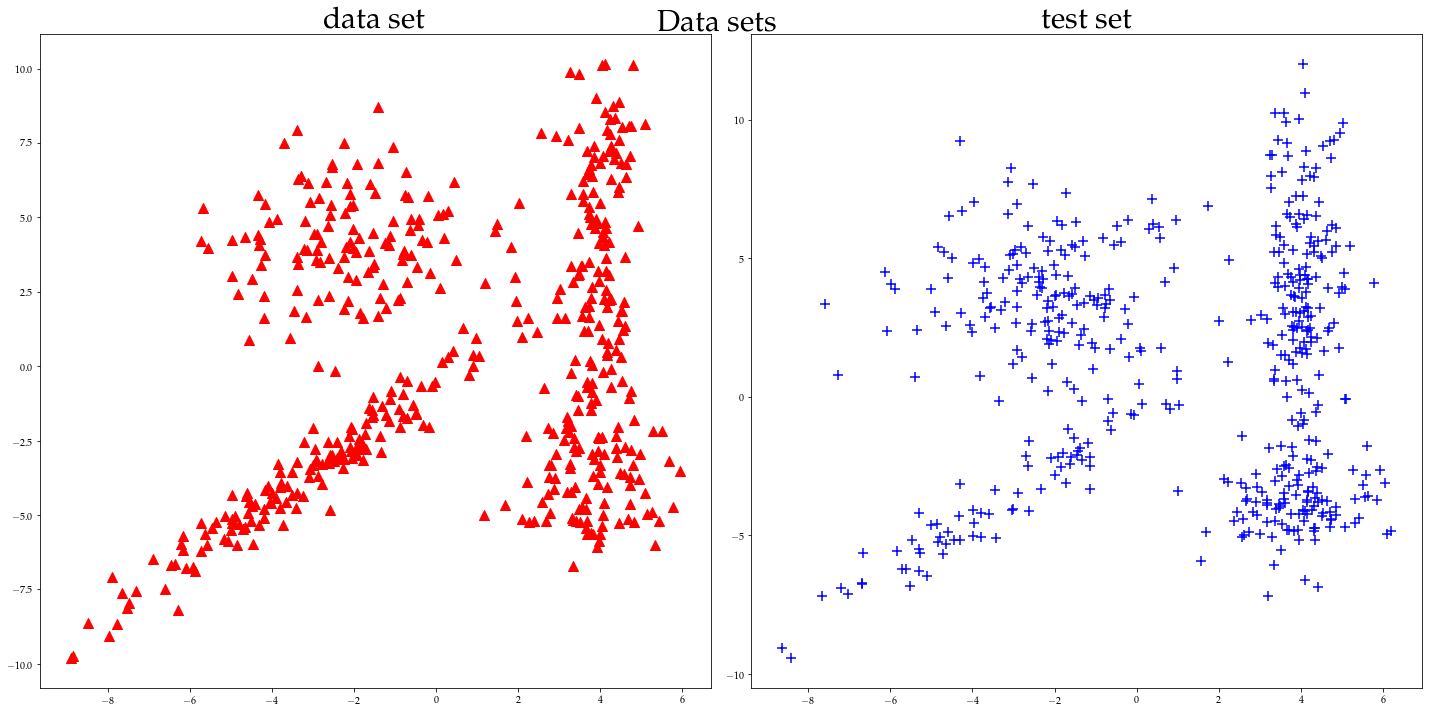

In [14]:
f, ax = plt.subplots(1, 2, figsize = (20, 10))

for j, t in enumerate(["data", "test"]):
    x = D[t].as_matrix()[:, :2]
    ax[j].scatter(x[:, 0], x[:, 1],
                  c = COLS[j], marker=MARKS[j], s = 100)
    ax[j].set_title(t + " set", size = 30);

f.suptitle("Data sets", fontsize = 30)
f.tight_layout();

# Classes

## Kmeans

In [ ]:
class K_means(object):
    """
    K-means clustering class
    """
    def __init__(self, K):
        self.K = K
        self.C = None
        self.A = None
        return
    def _random_centroid(self, datax):
        """
        Draw centroids chosen uniformly at random among the data
        """
        np.random.shuffle(datax)
        return datax[:self.K].reshape(self.K, 1, -1)
    def _assignment(self, datax):
        """
        Assign each point to the closet centroid
        """
        # Compute the distance matrix from each point to each centroid
        distance_matrix = np.linalg.norm(np.tile(datax, (self.K, 1, 1)) - self.C, axis = 2)
        # Get the argmin of the distance for all centroids
        self.A = distance_matrix.argmin(axis = 0)
#     def _distance(self, datax):
#         """
#         Compute the distance matrix from datax to centroids
#         """
#         # dist_mat[k][point] : distance from point to centroid centroid k
#         dist_mat = np.linalg.norm(np.tile(datax, (self.K, 1, 1)) - self.C, axis = 2)
    def fit(self, datax):
        """
        """
        # Initialisation
        ## Of centroids
        self.C = random_centroid(datax)
        ## Of distance matrix

    def predict(self, datax,  threshold = 0.5):
        """
        Compute p(y = 1 | x) and compare it with a treshold to classify the point.
        If p(y = 1 | x) > threshold, returns 1, else return 0
        """
        X = self.resize(datax)
        Ypred = 1 / (np.sqrt(2 * np.pi * self.sigma_square)) * \
         np.exp(-0.5 * (1 - X.dot(self.w))**2 / self.sigma_square)
        Ypred[Ypred >= threshold] = 1
        Ypred[Ypred < threshold] = 0
        return Ypred
    def score(self, datax, datay,):
        """
        Given data and their label, return the correct percentage of classification
        """
        return (self.predict(datax) == datay.reshape(-1 ,1)).sum() / len(datay)